### 为什么需要蒙特卡洛方法

1.解析解（closed-form solution）往往不存在，Black-Scholes 模型等有解析解的情况其实非常有限（例如：欧式期权，无分红股票）。

一旦模型更复杂，比如：

- 美式期权（可提前行权）

- 路径依赖型衍生品（Barrier Options、Asian Options 等）

- 标的价格过程更复杂（随机波动率、跳跃扩散过程）

 解析解就不存在或难以得到。此时 数值方法 是必须的。Monte Carlo 就是其中最通用的一种。

2. Monte Carlo 的通用性和灵活性

Monte Carlo 方法的思路是：

大量随机采样路径 → 计算期权收益 → 取平均 → 贴现 = 期权价值

它几乎不依赖于模型的复杂性，只要能模拟标的资产的随机过程，就能定价。

不管是复杂 payoff、复杂路径依赖、还是多资产（basket options），Monte Carlo 都能处理。

3. 高维问题下的优势

其他数值方法（如 PDE 差分法、树形法 Binomial/Trinomial Tree）在高维时会遇到 维度灾难。

Monte Carlo 的收敛速度与维度无关（始终是 𝑂(1/𝑁)）。

所以在高维金融产品（如多资产期权、信用风险组合）中，Monte Carlo 更加可行。

### 求解圆周率

In [6]:
import numpy as np

def mc_pi(n_samples=1_000_000, seed=None, ci_level=0.95):
    rng = np.random.default_rng(seed)
    x = rng.random(n_samples)
    y = rng.random(n_samples)
    hits = np.count_nonzero(x*x + y*y <= 1.0)
    p_hat = hits / n_samples
    pi_hat = 4.0 * p_hat

    z = 1.959963984540054 if abs(ci_level-0.95) < 1e-12 else \
        np.sqrt(2)*np.erfcinv(2*(1-ci_level))
    se = 4.0 * np.sqrt(p_hat * (1 - p_hat) / n_samples)
    ci = (pi_hat - z*se, pi_hat + z*se)
    return pi_hat, se, ci

pi_est, se, ci = mc_pi(1_000_000, seed=42)
print(pi_est)


3.142436


### 纯python

In [2]:
# -*- coding: utf-8 -*-
"""
Mote-Carlo Simulation with pure python
"""
from time import time
from math import exp, sqrt, log
from random import gauss, seed

seed(20000)
t0 = time()
S0 = 100
K = 100.
T = 1.0
r = 0.05
sigma = 0.2
M = 50  # 时间段数
dt = T / M
I = 250000  # 路径数

S = []
for i in range(I):
    path = []  # 生成新的路径
    for t in range(M + 1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0.0, 1.0)  # 布朗运动
            St = path[t-1] * exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)
            path.append(St)
    S.append(path)

C0 = exp(-r * T) * sum([max(path[-1]-K, 0) for path in S]) / I

tpy = time() - t0
print("European Option Value %7.3f" % C0)
print("Duration in seconds %7.3f" % tpy)


European Option Value  10.421
Duration in seconds  14.808


### 向量化处理

In [3]:
# -*- coding: utf-8 -*-
"""
Mote-Carlo Simulation with vector
"""
import numpy as np

from math import exp, sqrt, log
from time import time

t0 = time()
np.random.seed(20000)
S0 = 100.0
K = 105.0
T = 1.0
r = 0.05
sigma = 0.2
M = 50
dt = T / M
I = 250000

S = np.zeros((M+1, I))
S[0] = S0
for t in range(1, M+1):
    z = np.random.standard_normal(I)
    S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * sqrt(dt) * z)

C0 = exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I
tpy = time() - t0
print("European Option Value %7.3f" % C0)
print("Duration in seconds %7.3f" % tpy)


European Option Value   8.037
Duration in seconds   0.692


### 对数Euler

European Option Value   8.166
Duration in seconds   0.504


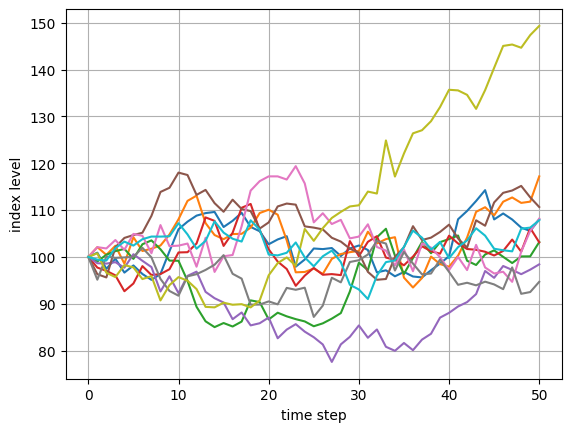

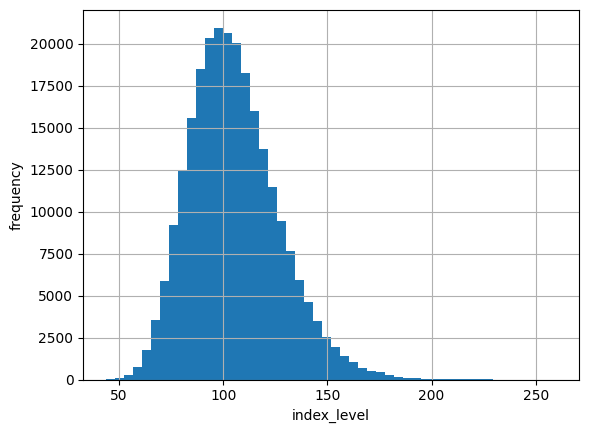

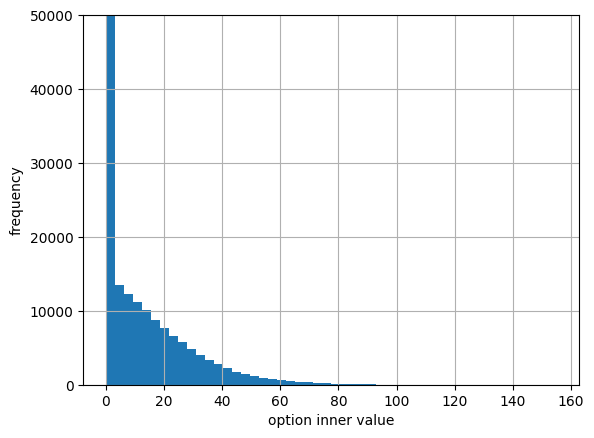

133533


In [4]:
# -*- coding: utf-8 -*-
import math
import numpy as np
import matplotlib.pyplot as plt

from time import time

t0 = time()
np.random.seed(20000)
S0 = 100.0
K = 105.0
T = 1.0
r = 0.05
sigma = 0.2
M = 50
dt = T / M
I = 250000

S = S0 * np.exp(np.cumsum((r-0.5*sigma**2)*dt + sigma*math.sqrt(dt)*np.random.standard_normal((M+1, I)), axis=0))
S[0] = S0
C0 = math.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I

tpy = time() - t0
print("European Option Value %7.3f" % C0)
print("Duration in seconds %7.3f" % tpy)

plt.plot(S[:, :10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')
plt.show()

plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index_level')
plt.ylabel('frequency')
plt.show()

plt.hist(np.maximum(S[-1]-K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')  # 期权内在价值
plt.ylabel('frequency')
plt.ylim(0, 50000)
plt.show()

print(sum(S[-1] < K))
